# Pedestrian Crash - Classification

In this attempt, i am splitting the HIC15 in ranges.
- Each range will have equal number of items.
- The number of ranges (bins) are 8.

## Importing the libraries

In [1]:
from pathlib import Path
import sys

sys.path.append("C:\\Users\\geork\\projects\\AIThesis\\src")
sys.path.append("C:\\Users\\geork\\projects\\AIThesis\\src\\src")
from src.dataset_reader import DatasetReaderCSV
from src.utilities import to_scrollable_table
from src.plot import plot_car_attributes_onehot, plot_pedestrian_attributes, plot_validation_acc_values, plot_hic15_max_binned
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical

## Read the dataset

I am reading the dataset from a file.
I've previously exported the dataset using another script.

In [2]:
path = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_2\\crash_simulation_classification.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Position"], errors="ignore")

In [3]:
to_remove_features = ["Id", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max"]
# Remove the unwanted columns
df = df.drop(columns=to_remove_features)

## Dataset Modifications

### One-hot-encoding in CarProfile column

In [4]:
# One-hot encoding the 'CarProfile' column
df = pd.get_dummies(df, columns=['CarProfile'])

# Display the DataFrame after one-hot encoding
print("\nDataFrame after One-hot Encoding:")
print(df)


DataFrame after One-hot Encoding:
      Velocity  Translation  Rotation  HIC15_max  CarProfile_FCR  \
0          100         -200         0     86.843            True   
1          100         -200       120   2361.697            True   
2          100         -200       150    573.455            True   
3          100         -200       180     84.702            True   
4          100         -200       210    592.965            True   
...        ...          ...       ...        ...             ...   
1195        80          400       300    623.367           False   
1196        80          400        30    140.360           False   
1197        80          400       330    367.018           False   
1198        80          400        60   1317.014           False   
1199        80          400        90   1861.807           False   

      CarProfile_MPV  CarProfile_RDS  CarProfile_SUV  
0              False           False           False  
1              False           False  

### Separate the HIC15_max column values into bin ranges from Q1 to Q8

In [5]:
NUM_OF_BINS = 8
# Create quantile bins
y_binned, bin_edges = pd.qcut(df['HIC15_max'], q=NUM_OF_BINS, labels=[f'Q{i+1}' for i in range(NUM_OF_BINS)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Add the binned variable as a new column to the DataFrame
df['HIC15_max_binned'] = y_binned
df = df.drop(columns=["HIC15_max"], errors="ignore")

# Now dfn_regr has the binned column
print(df.head())

# Print the count of each distinct value of HIC15_max_binned
print("\nCount of each distinct value of HIC15_max_binned:")
print(df['HIC15_max_binned'].value_counts().sort_index())

Ranges for each quantile bin:
Q1: 0.0 to 113.893625
Q2: 113.893625 to 444.45125
Q3: 444.45125 to 988.397375
Q4: 988.397375 to 1826.8964999999998
Q5: 1826.8964999999998 to 3490.965375
Q6: 3490.965375 to 7791.7429999999995
Q7: 7791.7429999999995 to 19452.69675
Q8: 19452.69675 to 277304.682
   Velocity  Translation  Rotation  CarProfile_FCR  CarProfile_MPV  \
0       100         -200         0            True           False   
1       100         -200       120            True           False   
2       100         -200       150            True           False   
3       100         -200       180            True           False   
4       100         -200       210            True           False   

   CarProfile_RDS  CarProfile_SUV HIC15_max_binned  
0           False           False               Q1  
1           False           False               Q5  
2           False           False               Q3  
3           False           False               Q1  
4           False        

## Dataset Insights

### Dataset Head

In [6]:
# Print 10 random rows from the DataFrame
df.sample(n=10)

,Velocity,Translation,Rotation,CarProfile_FCR,CarProfile_MPV,CarProfile_RDS,CarProfile_SUV,HIC15_max_binned
715,20,400,300,False,False,True,False,Q5
742,40,-400,60,False,False,True,False,Q7
1094,60,-400,150,False,False,False,True,Q1
99,20,200,180,True,False,False,False,Q1
834,60,400,270,False,False,True,False,Q6
1078,40,400,60,False,False,False,True,Q4
1040,40,-400,30,False,False,False,True,Q2
240,80,-200,0,True,False,False,False,Q1
825,60,200,330,False,False,True,False,Q5
681,20,-400,330,False,False,True,False,Q4


### Dataset description

In [7]:
print(df.describe())

          Velocity  Translation     Rotation
count  1200.000000  1200.000000  1200.000000
mean     60.000000     0.000000   165.000000
std      28.296064   282.960637   103.604754
min      20.000000  -400.000000     0.000000
25%      40.000000  -200.000000    82.500000
50%      60.000000     0.000000   165.000000
75%      80.000000   200.000000   247.500000
max     100.000000   400.000000   330.000000


### Dataset table

In [8]:
to_scrollable_table(df)

Velocity,Translation,Rotation,CarProfile_FCR,CarProfile_MPV,CarProfile_RDS,CarProfile_SUV,HIC15_max_binned
100,-200,0,True,False,False,False,Q1
100,-200,120,True,False,False,False,Q5
100,-200,150,True,False,False,False,Q3
100,-200,180,True,False,False,False,Q1
100,-200,210,True,False,False,False,Q3
100,-200,240,True,False,False,False,Q4
100,-200,270,True,False,False,False,Q6
100,-200,300,True,False,False,False,Q6
100,-200,30,True,False,False,False,Q3
100,-200,330,True,False,False,False,Q2


### Car profile attributes

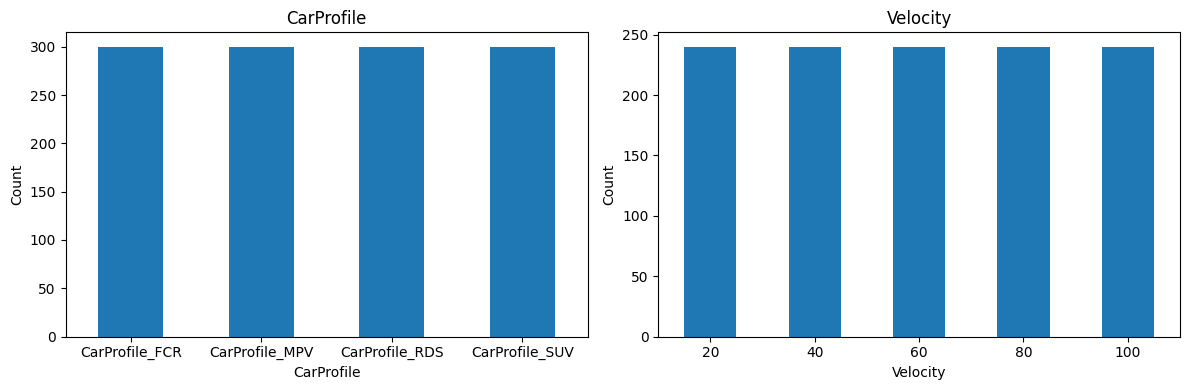

In [9]:
plot_car_attributes_onehot(df)

### Pedestrian attributes

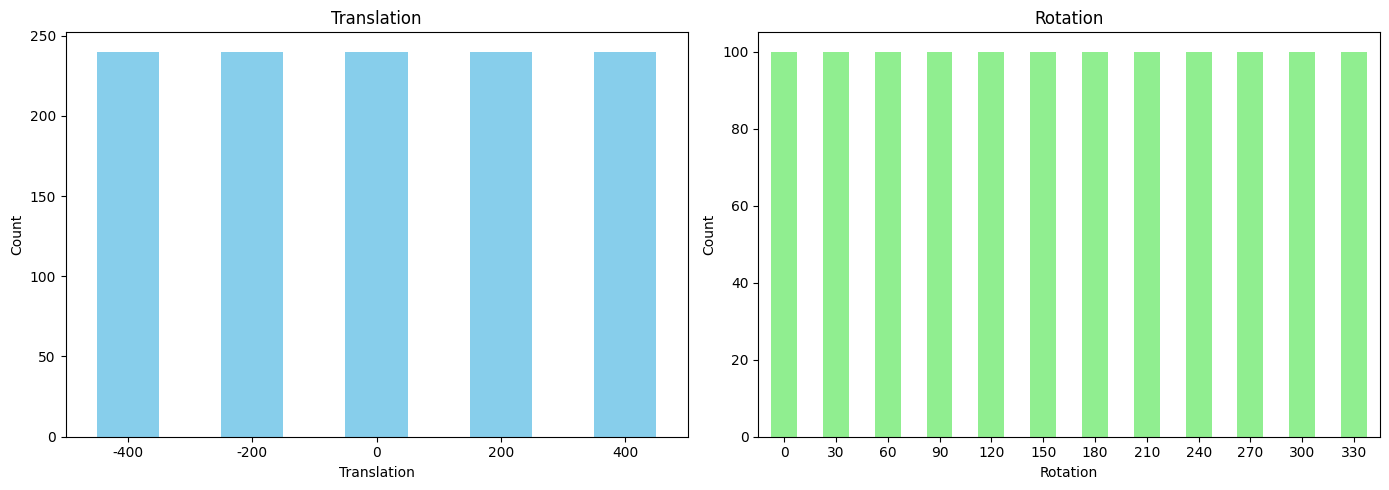

In [10]:
plot_pedestrian_attributes(df)

### Target attributes

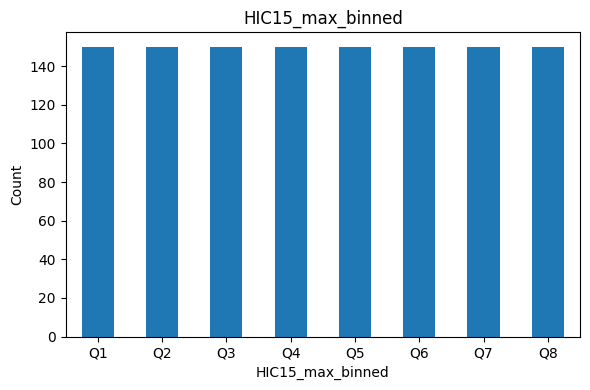

In [11]:
plot_hic15_max_binned(df)


## Perform classification on multiple targets

In [12]:
# Split the data into features and target
X = df.drop(columns=["HIC15_max_binned"])
y = df["HIC15_max_binned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\geork\AppData\Local\Temp\ipykernel_3080\3561641258.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)
c:\Users\geork\projects\AIThesis\src\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2070 - loss: 2.4810
Epoch 1: val_loss improved from inf to 2.21792, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_2\5_2_1\model_5_2_1.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2073 - loss: 2.4801 - val_accuracy: 0.2917 - val_loss: 2.2179
Epoch 2/200
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3500 - loss: 2.1161
Epoch 2: val_loss improved from 2.21792 to 2.00655, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_2\5_2_1\model_5_2_1.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3494 - loss: 2.1133 - val_accuracy: 0.3458 - val_loss: 2.0065
Epoch 3/200
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3701 - loss: 1.9338
Epoch 3: val_loss improved from 2.00655 to 1.89670, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_2\5_2_1\model_5_2_1.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accura

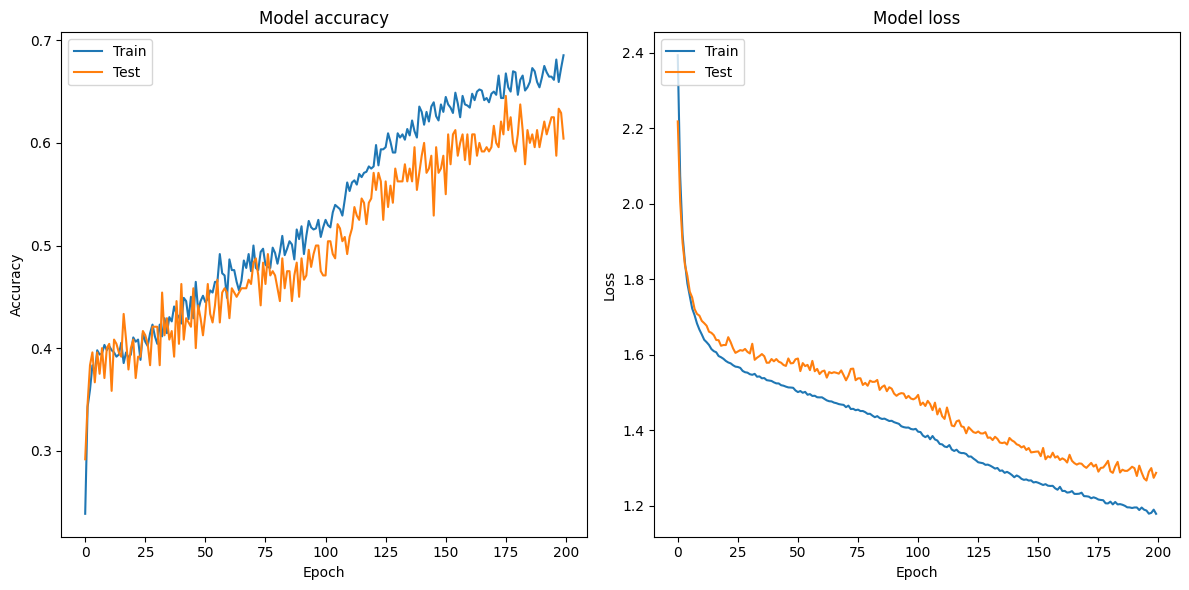

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


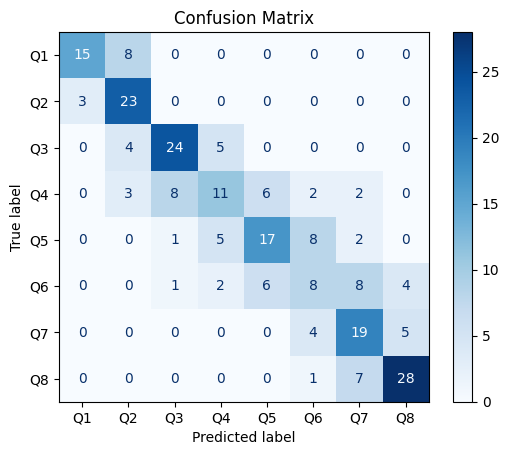

: 

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

# Encode target labels
label_encoder = LabelEncoder()
df['HIC15_max_binned'] = label_encoder.fit_transform(df['HIC15_max_binned'])

# Split features and target
X = df.drop(columns=['HIC15_max_binned'])
y = df['HIC15_max_binned']

# Convert boolean columns to integers
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the neural network model
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Multi-class classification

# Step 7: Build and train the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Multi-class classification


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
filepath = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_2\\5_2_1\\model_5_2_1.keras")
# Define a callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                              save_best_only=True, mode='min', verbose=1)

# early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# Train the model
#history = model.fit(X_train, y_train, epochs=500, batch_size=10, validation_data=(X_test, y_test))

# Train the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=200, batch_size=10, 
                    validation_data=(X_test, y_test), 
                    callbacks=[
                        checkpoint, 
                        #early_stopping
                        ])

# Load the best model
best_model = load_model(filepath)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Best Test Accuracy: {accuracy * 100:.2f}%')

plot_validation_acc_values(history)

# Predict the classes of the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()